<p align="center">
  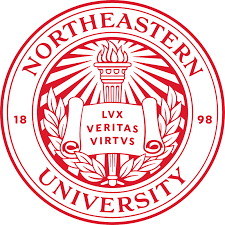
</p>

### <center> Northeastern University </center>
### <center>College of Professional Studies</center>
### <center>ALY 6980: Capstone</center>

### <center>Sponsor:Cloudport</center>

### CNN Code for Brain Tumor Classification of MRI Images
### Author: Sujay Torvi



In [36]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
import seaborn as sns
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report, confusion_matrix

### This code defines a function to configure TPU if available and handles exceptions, ensuring the appropriate distributed training strategy is set up.

### This function attempts to set up a TPU (Tensor Processing Unit) if available and falls back to GPU/CPU in case of exceptions, providing a unified distributed training strategy.

In [2]:
# Ignore warnings
tf.get_logger().setLevel('ERROR')

# Function to set up TPU (Tensor Processing Unit) if available
def setup_tpu():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Device:', tpu.master())
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    except:
        strategy = tf.distribute.get_strategy()
    return strategy

strategy = setup_tpu()

### This section sets up various constants used in the code, including automatic tuning, batch size, image size, dimensions, and the number of classes in the dataset.

In [3]:
# Constants
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
IMAGE_DIM = 150
EPOCHS = 100
NUM_CLASSES = 4  # Number of classes

### This function utilizes TensorFlow's image dataset loading API, allowing the user to load and preprocess datasets from a specified directory, considering validation split, subset, seed, image size, and batch size.


In [4]:
# Function to load image datasets from directory
def load_image_dataset(directory, subset):
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        validation_split=0.2,
        subset=subset,
        seed=2024,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
    )

### This section uses the previously defined function to load and preprocess training and validation image datasets from a specified directory. Additionally, it sets up class names for better interpretation.


In [5]:
# Load training and validation datasets
train_ds = load_image_dataset("/Users/sujaymukundtorvi/Desktop/ALY 6980 Capstone/archive/brain_tumor_dataset", "training")
val_ds = load_image_dataset("/Users/sujaymukundtorvi/Desktop/ALY 6980 Capstone/archive/brain_tumor_dataset", "validation")

# Define class names
class_names = ['no', 'yes']
train_ds.class_names = class_names
val_ds.class_names = class_names

Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.


2024-03-10 16:21:51.065770: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-10 16:21:51.065831: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-10 16:21:51.065853: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-10 16:21:51.066190: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-10 16:21:51.066576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### This code snippet visualizes a grid of sample images from the training dataset. It showcases nine images along with their corresponding class labels for a quick overview of the dataset.

2024-03-10 16:22:02.539284: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [203]
	 [[{{node Placeholder/_0}}]]
2024-03-10 16:22:02.539565: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [203]
	 [[{{node Placeholder/_4}}]]


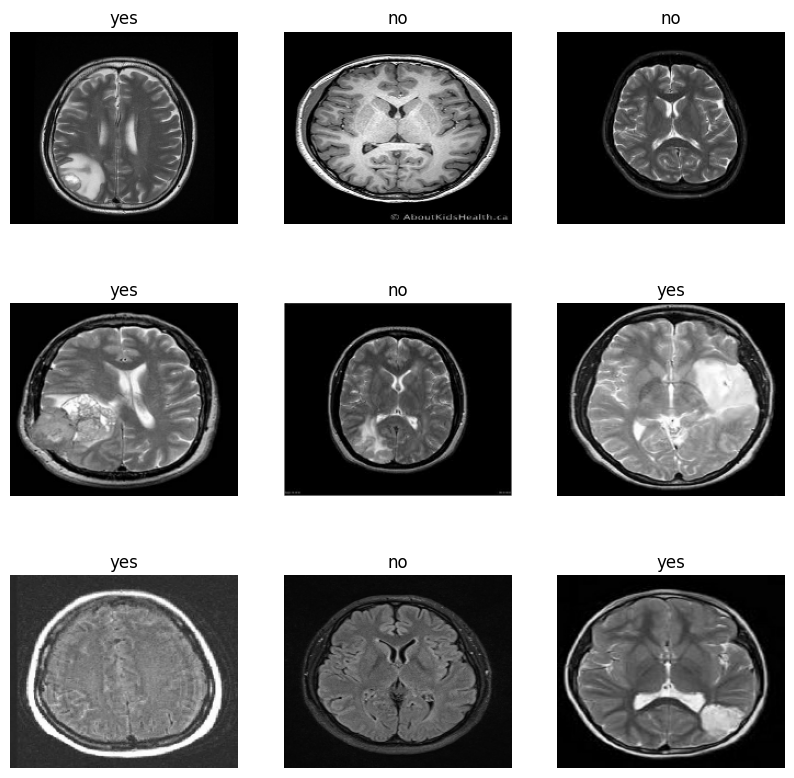

In [6]:
# Display sample images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

### This function performs one-hot encoding on image labels, converting them into a categorical format suitable for training neural networks.

In [7]:
# Function to one-hot encode labels
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

### This code block utilizes the previously defined one-hot encoding function to transform the image labels in both the training and validation datasets. Additionally, it caches and prefetches the datasets to enhance performance during training.

In [8]:
# Apply one-hot encoding to datasets
train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

# Cache and prefetch datasets for better performance
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### This function calculates the number of images available for each class in the dataset by iterating through the specified directory for each class and counting the files.


## CNN Model Definition 

### The conv_block function defines a convolutional block, utilizing separable convolution layers, batch normalization, and max pooling for feature extraction in a neural network. 

### The dense_block function constructs a dense block, consisting of a dense layer with activation, batch normalization, and dropout for regularization, enhancing the neural network's capacity to learn complex patterns. 

### Finally, the build_model function assembles the neural network model by stacking various layers, including resizing, convolutional blocks, dropout, and dense blocks, culminating in an output layer with softmax activation for multi-class classification.

In [60]:
def define_VGG_NET():
    # load base model
    vgg16_weight_path = 'imagenet'
    base_model = VGG16(
        weights=vgg16_weight_path,
        include_top=False, 
        input_shape=IMAGE_SIZE + (3,)
    )
    return base_model

# Function to build the model for binary classification
def build_binary_model():
    model = tf.keras.Sequential()
    model.add(define_VGG_NET())
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

    model.layers[0].trainable = False
    METRICS = [tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.CategoricalAccuracy(name='acc'), tf.metrics.F1Score()]

    model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    metrics=METRICS
    )

    model.summary()
    return model

### This code block utilizes TensorFlow's GPU/TPU strategy to build and compile the previously defined model. It incorporates performance metrics such as AUC, categorical accuracy, and F1 score, using the Adam optimizer and categorical crossentropy loss for training.


In [59]:
# Build and compile the model using TPU strategy
with strategy.scope():
    model = build_binary_model()
    METRICS = [tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.CategoricalAccuracy(name='acc'), tf.metrics.F1Score()]
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 6, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 15360)             0         
                                                                 
 dropout_14 (Dropout)        (None, 15360)             0         
                                                                 
 dense_12 (Dense)            (None, 4)                 61444     
                                                                 
Total params: 14776132 (56.37 MB)
Trainable params: 61444 (240.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


### This code defines a learning rate decay function for exponential decay, along with callbacks for model checkpointing and early stopping. These components are crucial for optimizing the training process by adjusting the learning rate and saving the best model. We now fit the CNN model.

In [62]:
# Define constants
EPOCHS = 50
BATCH_SIZE = 16
IMAGE_SIZE = (176, 208)

# Model checkpoint callback
checkpoint_cb = ModelCheckpoint("brain_tumor_cnn_model.h5", save_best_only=True)

# Early stopping callback
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit_generator(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/50


/var/folders/sp/v8twrsv10_g63fpbmz91x1z80000gn/T/ipykernel_12961/3347521599.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


13/13 [==============================] - 6s 442ms/step - loss: 2.7727e-06 - auc: 0.9713 - acc: 0.9901 - f1_score: 0.4910 - val_loss: 1.2818 - val_auc: 0.9400 - val_acc: 0.9200 - val_f1_score: 0.4481
Epoch 2/50
13/13 [==============================] - 6s 463ms/step - loss: 2.6359e-06 - auc: 0.9713 - acc: 0.9901 - f1_score: 0.4910 - val_loss: 1.2802 - val_auc: 0.9400 - val_acc: 0.9200 - val_f1_score: 0.4481
Epoch 3/50
13/13 [==============================] - 6s 456ms/step - loss: 2.5114e-06 - auc: 0.9713 - acc: 0.9901 - f1_score: 0.4910 - val_loss: 1.2786 - val_auc: 0.9400 - val_acc: 0.9200 - val_f1_score: 0.4481
Epoch 4/50
13/13 [==============================] - 6s 433ms/step - loss: 2.3981e-06 - auc: 0.9713 - acc: 0.9901 - f1_score: 0.4910 - val_loss: 1.2770 - val_auc: 0.9400 - val_acc: 0.9200 - val_f1_score: 0.4481
Epoch 5/50
13/13 [==============================] - 5s 420ms/step - loss: 2.2936e-06 - auc: 0.9713 - acc: 0.9901 - f1_score: 0.4910 - val_loss: 1.2755 - val_auc: 0.9400 - 

Epoch 40/50
13/13 [==============================] - 5s 425ms/step - loss: 7.9393e-07 - auc: 0.9721 - acc: 0.9852 - f1_score: 0.4894 - val_loss: 1.2377 - val_auc: 0.9400 - val_acc: 0.9200 - val_f1_score: 0.4516
Epoch 41/50
13/13 [==============================] - 5s 419ms/step - loss: 7.7807e-07 - auc: 0.9721 - acc: 0.9852 - f1_score: 0.4894 - val_loss: 1.2369 - val_auc: 0.9400 - val_acc: 0.9200 - val_f1_score: 0.4516
Epoch 42/50
13/13 [==============================] - 5s 431ms/step - loss: 7.6046e-07 - auc: 0.9721 - acc: 0.9852 - f1_score: 0.4894 - val_loss: 1.2361 - val_auc: 0.9400 - val_acc: 0.9200 - val_f1_score: 0.4516
Epoch 43/50
13/13 [==============================] - 5s 412ms/step - loss: 7.4460e-07 - auc: 0.9721 - acc: 0.9852 - f1_score: 0.4894 - val_loss: 1.2353 - val_auc: 0.9400 - val_acc: 0.9200 - val_f1_score: 0.4516
Epoch 44/50
13/13 [==============================] - 5s 426ms/step - loss: 7.2875e-07 - auc: 0.9721 - acc: 0.9852 - f1_score: 0.4894 - val_loss: 1.2345 - va

### This section assigns variables for training metrics, such as training and validation AUC and loss. It then visualizes the training and validation accuracies and losses across epochs to assess model performance.

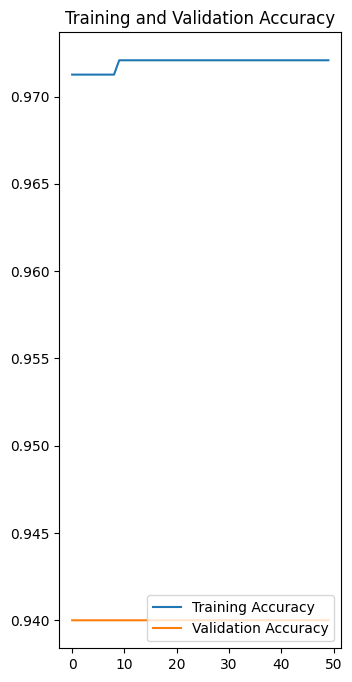

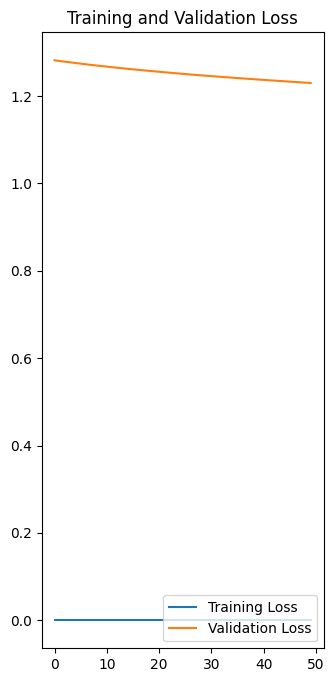

In [63]:
# Assign variables
EPOCHS = 50 #Early stopping epoch value
auc = history.history['auc']
val_auc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracies
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), auc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_auc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation losses
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

### This function resizes input images to a specified target size, which is essential for preparing images before feeding them into the neural network for training, validation, or testing.

In [64]:
# Define a function to resize images
def resize_images(image, label):
    resized_image = tf.image.resize(image, IMAGE_SIZE)
    return resized_image, label

In [65]:
# Apply resizing to validation dataset
val_ds_resized = val_ds.map(resize_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

### The code loads the test dataset from a specified directory, configuring it with the desired image size and batch size for evaluation after model training.

In [70]:
# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/sujaymukundtorvi/Desktop/ALY 6980 Capstone/Alzheimer_s Dataset/Test/",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 1279 files belonging to 4 classes.


### The test dataset undergoes preprocessing, including image resizing and one-hot encoding, to match the training and validation data. The trained model is then evaluated on the test set to assess its performance.

In [67]:
# Apply preprocessing and one-hot encoding to test dataset
test_ds = test_ds.map(resize_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Evaluate the model on the test dataset
_ = model.evaluate(test_ds)

2024-03-10 17:58:00.472650: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [253]
	 [[{{node Placeholder/_4}}]]
2024-03-10 17:58:00.472921: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [253]
	 [[{{node Placeholder/_4}}]]


16/16 [==============================] - 6s 365ms/step - loss: 0.8208 - auc: 0.9529 - acc: 0.9368 - f1_score: 0.4589


### The code loads the previously trained and saved model from the specified file path for further analysis and predictions.

In [71]:
# Load the trained model
model_path = '/Users/sujaymukundtorvi/Desktop/ALY 6980 Capstone/brain_tumor_cnn_model.h5'
model = tf.keras.models.load_model(model_path)

### This function takes an image file path and preprocesses the image for prediction, including resizing it to a specified target size.

In [72]:
# Define a function to preprocess an image
def preprocess_image(image_path, target_size=(176, 208)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

### This segment collects true and predicted labels for the validation dataset, enabling the generation of a confusion matrix and classification report for evaluating model performance.

In [73]:
# Collect true and predicted labels for confusion matrix and classification report
y_true = []
y_pred = []

for img_batch, label_batch in val_ds_resized:
    # Predict
    preds = model.predict(img_batch, verbose=False)
    pred_labels = np.argmax(preds, axis=1)
    y_pred.extend(pred_labels)

    # Convert one-hot encoded labels to indices for true labels
    true_labels = np.argmax(label_batch.numpy(), axis=1)
    y_true.extend(true_labels)

2024-03-10 17:59:42.464568: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50]
	 [[{{node Placeholder/_0}}]]
2024-03-10 17:59:42.465021: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50]
	 [[{{node Placeholder/_0}}]]
2024-03-10 17:59:42.618415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### This block of code defines a function to plot a grid of images from the validation dataset along with their actual and predicted labels. The function uses the trained model to make predictions and displays the images with corresponding information.

In [74]:
# Plot images with predictions
def plot_images_predictions(dataset, class_names, model):
    plt.figure(figsize=(10, 10))

    # Unbatching dataset and taking 9 samples
    for images, labels in dataset.unbatch().batch(9).take(1):
        predictions = model.predict(images)
        predicted_class_indices = np.argmax(predictions, axis=1)
        confidences = np.max(predictions, axis=1)

        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

            # Adjust for one-hot encoded labels or tensor labels
            actual_idx = np.argmax(labels[i].numpy()) if labels[i].numpy().size > 1 else labels[i].numpy()
            actual_label = class_names[actual_idx]
            predicted_label = class_names[predicted_class_indices[i]]
            confidence = confidences[i]

            plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}")

    plt.tight_layout()
    plt.show()

2024-03-10 17:59:47.309941: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50]
	 [[{{node Placeholder/_0}}]]
2024-03-10 17:59:47.310270: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 201ms/step


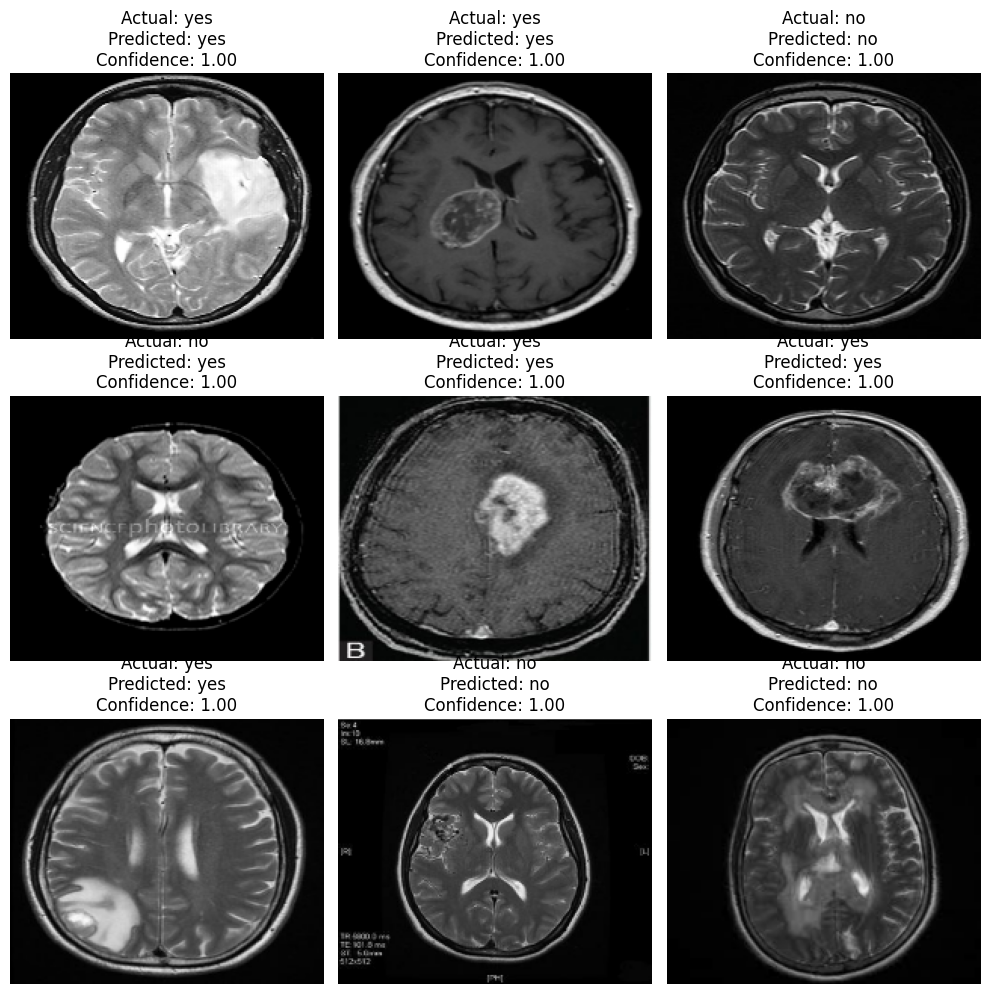

In [75]:
# Assuming val_ds is defined and class_names is a list of class names
plot_images_predictions(val_ds, class_names, model)

### This section generates and displays a confusion matrix based on the true and predicted labels from the validation dataset. The confusion matrix provides insights into the model's performance across different classes.

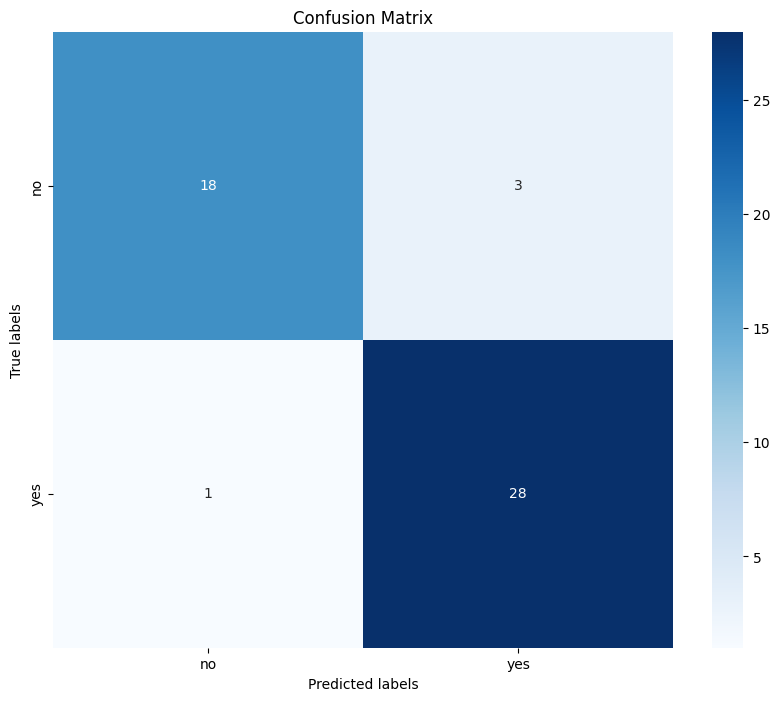

              precision    recall  f1-score   support

          no       0.95      0.86      0.90        21
         yes       0.90      0.97      0.93        29

    accuracy                           0.92        50
   macro avg       0.93      0.91      0.92        50
weighted avg       0.92      0.92      0.92        50



In [76]:
# Generate and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate and display the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)